In [1]:
import numpy as np
import tensorflow as tf
from stochastic.processes.continuous import FractionalBrownianMotion
import fbm
from fbm import fgn,mbm,mgn,times
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib notebook

In [27]:
def gen_fbm_data(nsamples,ntimes,hurst_const=None):
    """ 
    Function to produce fractional brownian motion data for neural network 
    training and testing
    Inputs: nsamples; number of samples, ntimes; number of times
    Outputs: traindata; training data for NN, trainlabels; labels associated 
            with traindata
    """
    data = np.empty((nsamples,ntimes+1,3))
    labels = np.empty((nsamples,1))
    for i in range(0,nsamples):
        if hurst_const == None:
            hurst_exp = np.random.uniform(0.,1.)
        else:
            hurst_exp = hurst_const
        fbm = FractionalBrownianMotion(hurst=hurst_exp,t=1,rng=None)
        x = fbm.sample(ntimes)
        y = fbm.sample(ntimes)
        z = fbm.sample(ntimes)
        #apply differencing and normalization on the data
        #dx = (x[1:]-x[0:-1])/(np.amax(x)-np.amin(x))
        #dy = (y[1:]-x[0:-1])/(np.amax(y)-np.amin(y))
        #dz = (z[1:]-x[0:-1])/(np.amax(z)-np.amin(z))
        data[i,:] = np.array([x,y,z]).transpose()
        labels[i,:] = hurst_exp
        
    return data,labels

def gen_fbm_subtrack(hurst_exp,subtrack_length):
    
    fbm = FractionalBrownianMotion(hurst=hurst_exp,t=1,rng=None)
    
    x = fbm.sample(subtrack_length)
    y = fbm.sample(subtrack_length)
    dx = x[1:]-x[0:-1]
    dy = y[1:]-y[0:-1]
    
    dxdy = np.vstack((dx,dy)).transpose()
    return dxdy

def gen_fbm_track(hurst_exp,subtrack_length,track_length,init_pos = [0,0]):
    
    #xy = np.empty((subtrack_length,2))
    xy = init_pos
    
    for i in np.arange(track_length):
        
        dxdy = gen_fbm_subtrack(hurst_exp,subtrack_length)
        
        for j in np.arange(subtrack_length):
            
            xy = np.vstack((xy,xy[-1]+dxdy[j]))
        
    return xy

def boundary_checker(radius, xy_data):
    
    if xy_data[0]**2 + xy_data[1]**2 < radius**2:
        
        return True
    
    else:
        
        return False
        
def gen_fbm_track_collisions(hurst_exp,radius,subtrack_length,n_collisions, init_pos=[0,0]):
    
    xy = init_pos

    for i in np.arange(n_collisions):
        
        dxdy = gen_fbm_subtrack(hurst_exp,subtrack_length)
        print(i)
        print('---')
        
        flag = True
    
        while flag == True:
        
            for j,dxdy_vals in enumerate(dxdy):
                
                print(dxdy_vals)
                
                #print(j)

                xy_new = xy[-1]+dxdy[j]
                
                flag = boundary_checker(radius,xy_new)

                xy = np.vstack((xy,xy_new))
                
            flag = False

    
    return xy
    

In [28]:
def plot_random_walks(steps, init_pos=[0,0,0]):
    
    fig = plt.figure()
    ax = Axes3D(fig)
    for i,_ in enumerate(steps):
        ax.plot(steps[i,:,0],steps[i,:,1],steps[i,:,2])
        
    return

def plot_2d_fbm(data_fbm,radius):
    
    fig,ax = plt.subplots()

    plt.plot(data_fbm[:,0],data_fbm[:,1])
    
    circle = plt.Circle((0,0),radius,color='r',fill=False)
    ax.add_patch(circle)
    plt.show()
    
    

0
---
[-0.05170259 -0.01569014]
[-0.01534228 -0.00693389]
[0.00968526 0.01713985]
[-0.04669522  0.00119805]
[-0.04404994 -0.00160874]
[-0.0315012   0.02989857]
[-0.04381589  0.02853988]
[-0.00419215  0.01037074]
[-0.01548595  0.02685799]
[-0.01662267 -0.00434082]
[0.01541451 0.02659906]
[-0.01147452 -0.02655157]
[-0.03551142  0.01162355]
[-0.02256787  0.01789857]
[-0.02552942 -0.00779017]
[-0.06914366  0.0135049 ]
[-0.03343337  0.02885243]
[-0.04360708  0.02619924]
[0.00453084 0.0414669 ]
[-0.02975531  0.03744691]
[-0.02645892 -0.0002953 ]
[-0.03502046  0.01187022]
[-0.04666413  0.00347617]
[-0.00193896  0.00805001]
[-0.03467073 -0.00575767]
[-0.05763437 -0.04410874]
[-0.05410077 -0.05174114]
[-0.03103633 -0.05228636]
[-0.06998643 -0.02236317]
[-0.05506019 -0.01962252]
[-0.03184256 -0.03010024]
[-0.01886812 -0.01334176]
[-0.00163163  0.01442237]
[-0.02217708 -0.00583919]
[-0.0350355  -0.00621227]
[-0.02036861  0.00385178]
[-0.02084917  0.00026387]
[ 0.01142263 -0.02564811]
[ 0.01406936

<IPython.core.display.Javascript object>


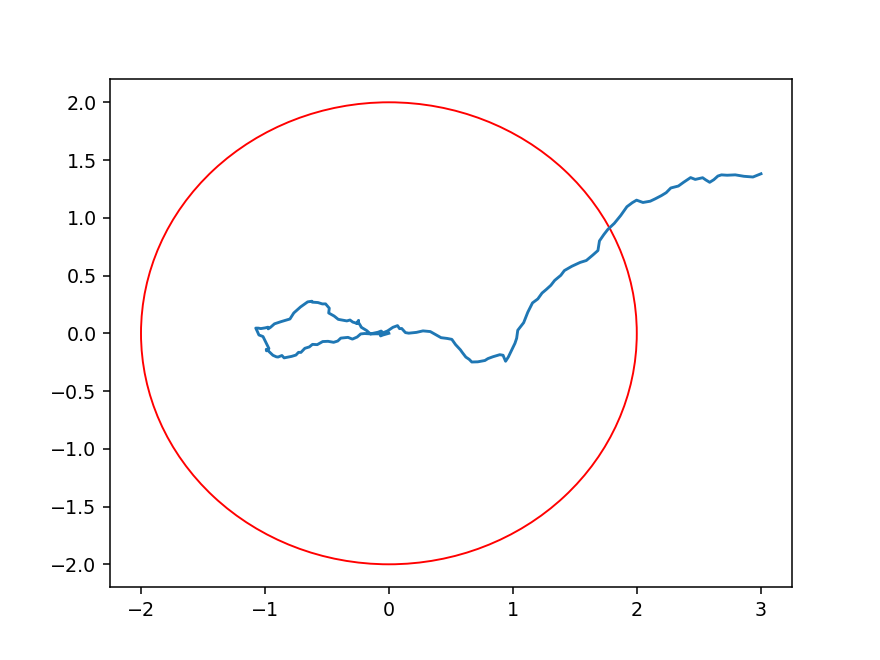

In [31]:
#data_new = gen_fbm_track(0.99,100,1)
data_new = gen_fbm_track_collisions(0.9,1,50,3,init_pos=[0,0])
plot_2d_fbm(data_new,2)

In [32]:
def h_sine(t):
    
    h_val = 0.5+0.4*np.sin(2*np.pi*t)
    
    return h_val

def h_step(t):
    
    print(max(t))
    
    h_val = np.piecewise(t, [t < max(t)//2, t >= max(t)//2], 
                         [lambda t: (t)//max(t), lambda t: 1-t//max(t)])

    return h_val
 
m = mbm(n=1000, hurst=h_sine, length=1, method='riemannliouville')
t = times(n=1000,length=1)

<IPython.core.display.Javascript object>


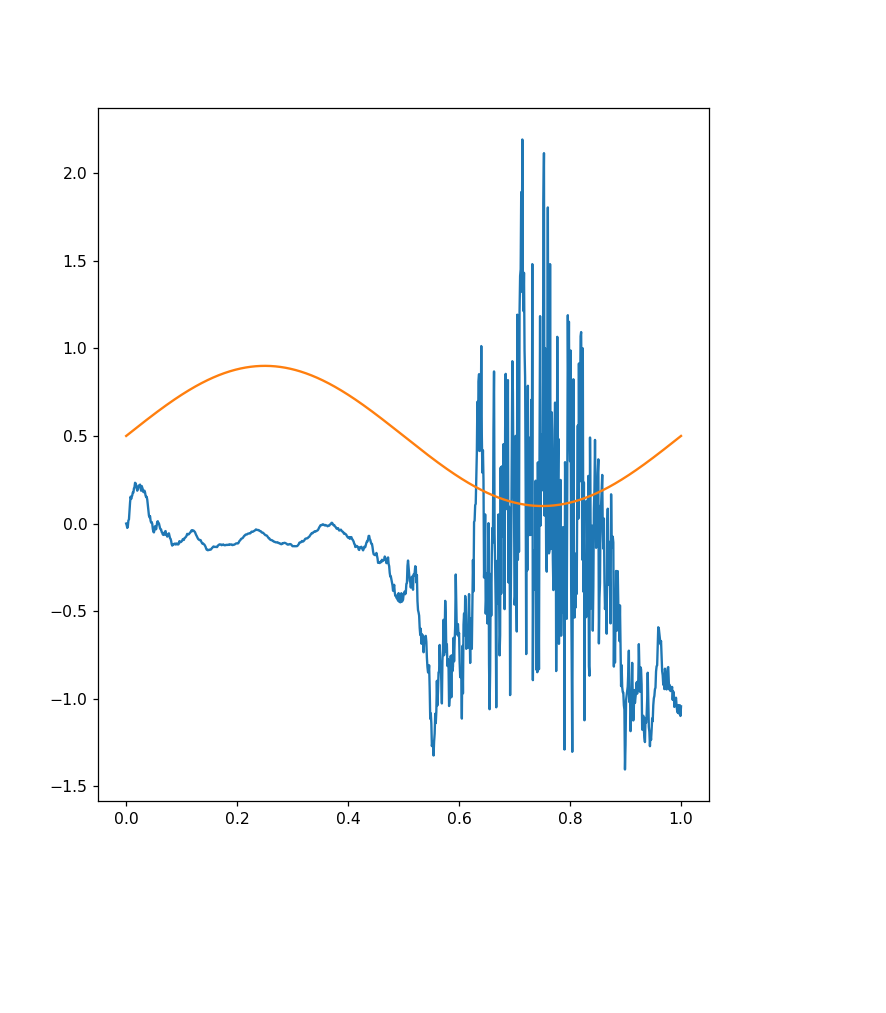

In [8]:
fig,ax = plt.subplots(figsize=(7,8))
plt.plot(t,m)
plt.plot(t,h_sine(t))

In [12]:
data_h = fgn(n=1024, hurst=0.75, length=1, method='daviesharte')

In [34]:
x = np.random.randint(0,4,10)
y = np.random.randint(0,4,10)
z = np.hstack((x,y))
print(x,y)
print(z)

[1 1 1 3 2 1 1 2 1 3] [3 1 0 3 0 3 1 1 0 3]
[1 1 1 3 2 1 1 2 1 3 3 1 0 3 0 3 1 1 0 3]


In [13]:
print(np.shape(data_h))

(1024,)
